## **preprocessing steps:**

In [ ]:
!pip install kaggle


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dubbakashivareddy","key":"f1b443d73a72fb875a1fd400300d9491"}'}

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/


In [ ]:
!kaggle datasets download -d manjilkarki/deepfake-and-real-images


Dataset URL: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images
License(s): unknown
 99% 1.67G/1.68G [00:12<00:00, 93.3MB/s]
100% 1.68G/1.68G [00:12<00:00, 141MB/s] 


In [ ]:
!unzip deepfake-and-real-images.zip


Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Validation/Real/real_5499.jpg  
  inflating: Dataset/Validation/Real/real_55.jpg  
  inflating: Dataset/Validation/Real/real_550.jpg  
  inflating: Dataset/Validation/Real/real_5500.jpg  
  inflating: Dataset/Validation/Real/real_5501.jpg  
  inflating: Dataset/Validation/Real/real_5502.jpg  
  inflating: Dataset/Validation/Real/real_5503.jpg  
  inflating: Dataset/Validation/Real/real_5504.jpg  
  inflating: Dataset/Validation/Real/real_5505.jpg  
  inflating: Dataset/Validation/Real/real_5506.jpg  
  inflating: Dataset/Validation/Real/real_5507.jpg  
  inflating: Dataset/Validation/Real/real_5508.jpg  
  inflating: Dataset/Validation/Real/real_5509.jpg  
  inflating: Dataset/Validation/Real/real_551.jpg  
  inflating: Dataset/Validation/Real/real_5510.jpg  
  inflating: Dataset/Validation/Real/real_5511.jpg  
  inflating: Dataset/Validation/Real/real_5512.jpg  
  inflating: Dataset/Validation/Real/real_5513.jpg  

## **Image size Identification:**

In [ ]:
import os
from PIL import Image

# Define the path to the dataset directory
dataset_dir = "/content/Dataset"

# Function to get the dimensions of images in a directory
def get_image_dimensions(directory):
    dimensions = set()
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):  # Filter image files
                file_path = os.path.join(root, file)
                with Image.open(file_path) as img:
                    dimensions.add(img.size)
    return dimensions

# Get dimensions of images in training, validation, and test directories
training_dimensions = get_image_dimensions(os.path.join(dataset_dir, "Training"))
validation_dimensions = get_image_dimensions(os.path.join(dataset_dir, "Validation"))
test_dimensions = get_image_dimensions(os.path.join(dataset_dir, "Test"))

# Combine dimensions from all sets
all_dimensions = training_dimensions.union(validation_dimensions, test_dimensions)

# Print the unique dimensions
print("Unique image dimensions in the dataset:")
for dimension in all_dimensions:
    print(dimension)


Unique image dimensions in the dataset:
(256, 256)


In [ ]:
train_dir = 'Dataset/Train'
validation_dir = 'Dataset/Validation'
test_dir = 'Dataset/Test'

In [ ]:
!ls

Dataset  deepfake-and-real-images.zip  sample_data


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import os

train_dir = 'Dataset/Train'
validation_dir = 'Dataset/Validation'
test_dir = 'Dataset/Test'

img_width, img_height = 150, 150

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    # target_size=(img_width, img_height),
    batch_size=128,
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    # target_size=(img_width, img_height),
    batch_size=128,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    # target_size=(img_width, img_height),
    batch_size=128,
    class_mode='binary',
    shuffle=False)

# Get the number of images in each class
def count_images_in_directory(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_count = len(os.listdir(class_path))
            class_counts[class_name] = class_count
    return class_counts

train_class_counts = count_images_in_directory(train_dir)
validation_class_counts = count_images_in_directory(validation_dir)
test_class_counts = count_images_in_directory(test_dir)

print("Number of images in each class for training set:")
print(train_class_counts)
print("\nNumber of images in each class for validation set:")
print(validation_class_counts)
print("\nNumber of images in each class for test set:")
print(test_class_counts)


Found 140002 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.
Number of images in each class for training set:
{'Fake': 70001, 'Real': 70001}

Number of images in each class for validation set:
{'Fake': 19641, 'Real': 19787}

Number of images in each class for test set:
{'Fake': 5492, 'Real': 5413}


## **Cropping the faces:**

In [ ]:
import cv2
import os

# Load the pre-trained face detection cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Function to detect faces and extract their coordinates
def detect_faces(image_path):
    # Read the image
    img = cv2.imread(image_path)
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    # Extract the coordinates of the faces
    face_coordinates = []
    for (x, y, w, h) in faces:
        face_coordinates.append((x, y, x + w, y + h))  # (x1, y1, x2, y2)
    return face_coordinates


In [ ]:

# Function to detect faces in an image and crop them
def detect_and_crop_faces(image_path, output_dir):
    # Read the image
    img = cv2.imread(image_path)
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    # Iterate through each detected face
    for i, (x, y, w, h) in enumerate(faces):
        # Crop the face region from the image
        cropped_face = img[y:y+h, x:x+w]
        # Save the cropped face as a new image file with a unique filename
        output_filename = os.path.join(output_dir, f"face_{i+1}_{os.path.basename(image_path)}")
        cv2.imwrite(output_filename, cropped_face)
        print(f"Saved face {i+1} from {os.path.basename(image_path)} as {output_filename}")


In [ ]:

# Function to iterate through images in the dataset directory and detect/crop faces
def detect_and_crop_faces_in_dataset(dataset_dir, output_dir):
    # Iterate through each directory (class) in the dataset (Train, Validation, Test)
    for split in os.listdir(dataset_dir):
        split_dir = os.path.join(dataset_dir, split)
        if os.path.isdir(split_dir):
            print("Split:", split)
            # Iterate through each image in the split directory
            for class_name in os.listdir(split_dir):
                class_dir = os.path.join(split_dir, class_name)
                if os.path.isdir(class_dir):
                    print("  Class:", class_name)
                    # Create the corresponding output directory
                    output_class_dir = os.path.join(output_dir, split, class_name)
                    os.makedirs(output_class_dir, exist_ok=True)
                    # Iterate through each image in the class directory
                    for image_file in os.listdir(class_dir):
                        image_path = os.path.join(class_dir, image_file)
                        # Check if the path is a file and has an image extension
                        if os.path.isfile(image_path) and image_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                            # Detect and crop faces in the image
                            detect_and_crop_faces(image_path, output_class_dir)

# Define the dataset directory and the output directory for cropped faces
dataset_dir = "/content/Dataset"
output_dir = "/content/Cropped_faces"

# Call the function to detect and crop faces in the dataset
detect_and_crop_faces_in_dataset(dataset_dir, output_dir)


Streaming output truncated to the last 5000 lines.
Saved face 2 from real_63087.jpg as /content/Cropped_faces/Train/Real/face_2_real_63087.jpg
Saved face 1 from real_50564.jpg as /content/Cropped_faces/Train/Real/face_1_real_50564.jpg
Saved face 2 from real_50564.jpg as /content/Cropped_faces/Train/Real/face_2_real_50564.jpg
Saved face 1 from real_27977.jpg as /content/Cropped_faces/Train/Real/face_1_real_27977.jpg
Saved face 1 from real_69150.jpg as /content/Cropped_faces/Train/Real/face_1_real_69150.jpg
Saved face 1 from real_58525.jpg as /content/Cropped_faces/Train/Real/face_1_real_58525.jpg
Saved face 1 from real_34086.jpg as /content/Cropped_faces/Train/Real/face_1_real_34086.jpg
Saved face 1 from real_13486.jpg as /content/Cropped_faces/Train/Real/face_1_real_13486.jpg
Saved face 1 from real_36181.jpg as /content/Cropped_faces/Train/Real/face_1_real_36181.jpg
Saved face 1 from real_25382.jpg as /content/Cropped_faces/Train/Real/face_1_real_25382.jpg
Saved face 1 from real_5118.j

## **Model Building:**

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define directories for cropped faces
cropped_faces_dir = '/content/Cropped_faces'
train_dir = os.path.join(cropped_faces_dir, 'Train')
validation_dir = os.path.join(cropped_faces_dir, 'Validation')
test_dir = os.path.join(cropped_faces_dir, 'Test')

# Define image data generators with normalization
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Define batch size and image dimensions
batch_size = 256
img_width, img_height = 150, 150

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 130754 images belonging to 2 classes.
Found 36926 images belonging to 2 classes.
Found 9771 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model architecture
def create_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Create the model
input_shape = (150, 150, 3)  # Adjust input shape according to your cropped face images
model = create_model(input_shape)


In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the maximum number of epochs
max_epochs = 100

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=max_epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size,
                    callbacks=[early_stopping])

# Print accuracy in each step of epoch
for i, acc in enumerate(history.history['accuracy']):
    print(f'Epoch {i+1}: Accuracy = {acc}')

Epoch 1/100
510/510 [==============================] - 147s 286ms/step - loss: 0.4292 - accuracy: 0.7878 - val_loss: 0.3392 - val_accuracy: 0.8629
Epoch 2/100
510/510 [==============================] - 146s 286ms/step - loss: 0.2423 - accuracy: 0.9005 - val_loss: 0.2632 - val_accuracy: 0.8932
Epoch 3/100
510/510 [==============================] - 147s 287ms/step - loss: 0.1939 - accuracy: 0.9207 - val_loss: 0.2486 - val_accuracy: 0.8921
Epoch 4/100
510/510 [==============================] - 146s 287ms/step - loss: 0.1657 - accuracy: 0.9320 - val_loss: 0.2401 - val_accuracy: 0.9037
Epoch 5/100
510/510 [==============================] - 148s 290ms/step - loss: 0.1440 - accuracy: 0.9415 - val_loss: 0.2072 - val_accuracy: 0.9133
Epoch 6/100
510/510 [==============================] - 149s 291ms/step - loss: 0.1248 - accuracy: 0.9495 - val_loss: 0.2181 - val_accuracy: 0.9074
Epoch 7/100
510/510 [==============================] - 146s 286ms/step - loss: 0.1111 - accuracy: 0.9550 - val_loss: 0

39/39 [==============================] - 9s 221ms/step
Confusion Matrix:
[[4319  413]
 [1186 3853]]


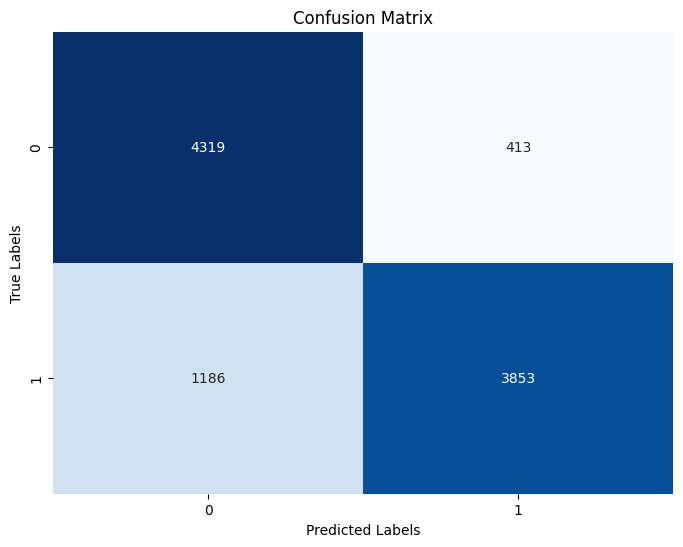


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.91      0.84      4732
           1       0.90      0.76      0.83      5039

    accuracy                           0.84      9771
   macro avg       0.84      0.84      0.84      9771
weighted avg       0.85      0.84      0.84      9771



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate the model on the test dataset
test_generator.reset()
preds = model.predict(test_generator, verbose=1)
y_pred = preds > 0.5  # Apply threshold for binary classification

# Convert labels from one-hot encoding to binary
y_true = test_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))


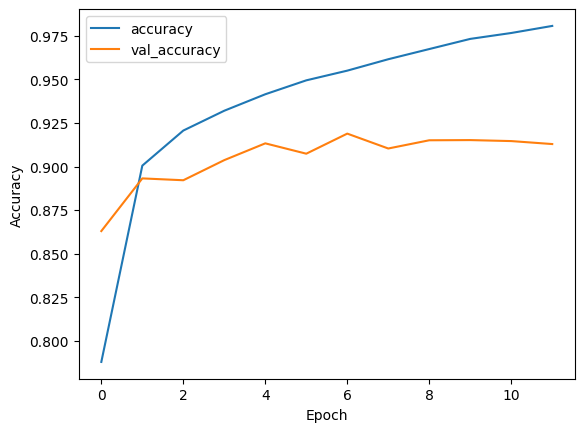

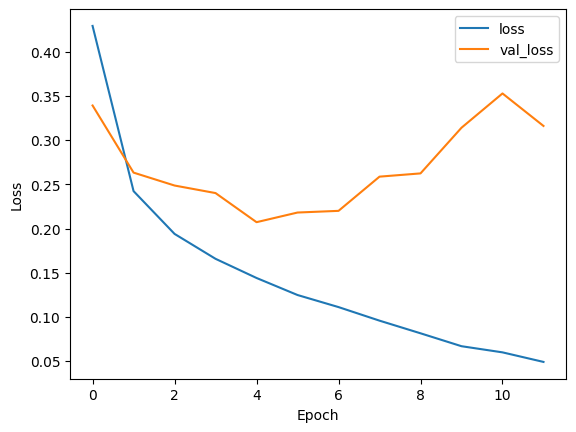

In [ ]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import numpy as np
from PIL import Image

# Define image dimensions
img_width, img_height = 150, 150  # Assuming the same input dimensions used during training

def preprocess_image(image_path):
    # Load image from file path
    img = Image.open(image_path)
    # Resize image to match input dimensions
    img = img.resize((img_width, img_height))
    # Convert image to numpy array and normalize pixel values
    img_array = np.array(img) / 255.0
    # Expand dimensions to match model input shape (add batch dimension)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def classify_image(image_path):
    # Preprocess the image
    img_array = preprocess_image(image_path)
    # Make prediction
    prediction = model.predict(img_array)
    # Interpret prediction
    if prediction > 0.5:
        return "Real"
    else:
        return "Fake"

# Example usage
image_path = '/content/Dataset/Test/Fake/fake_0.jpg'  # Replace with the path to your local image file
classification = classify_image(image_path)
print(f"The image is classified as: {classification}")


1/1 [==============================] - 0s 23ms/step
The image is classified as: Fake


**Model Prediction using External Link**


In [ ]:
import numpy as np
import requests
from PIL import Image
from io import BytesIO


# Define image dimensions
img_width, img_height = 150, 150  # Assuming the same input dimensions used during training

def preprocess_image(image_url):
    # Load image from URL
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))
    # Resize image to match input dimensions
    img = img.resize((img_width, img_height))
    # Convert image to numpy array and normalize pixel values
    img_array = np.array(img) / 255.0
    # Expand dimensions to match model input shape (add batch dimension)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def classify_image(image_url):
    # Preprocess the image
    img_array = preprocess_image(image_url)
    # Make prediction
    prediction = model.predict(img_array)
    # Interpret prediction
    if prediction > 0.5:
        return "Real"
    else:
        return "Fake"

# Example usage
image_url = 'https://imageio.forbes.com/specials-images/imageserve/5ecebee7938ec500060ab34f/0x0.jpg?format=jpg&crop=2336,2337,x1064,y702,safe&height=416&width=416&fit=bounds'  # Replace with the URL of the image you want to classify
classification = classify_image(image_url)
print(f"The image is classified as: {classification}")

1/1 [==============================] - 0s 22ms/step
The image is classified as: Real
